In [14]:
import json
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pickle
import math
import time
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

In [2]:
class ImprovedLSTMModel(nn.Module):
    def __init__(self, input_size=8, hidden_layer_size=64, num_layers=2, dropout=0.2, output_size=1):
        super(ImprovedLSTMModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.num_layers = num_layers
        self.input_size = input_size
        
        # LSTM layer with multiple layers and dropout
        self.lstm = nn.LSTM(
            input_size, 
            hidden_layer_size, 
            num_layers, 
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0  # Dropout between LSTM layers
        )
        
        # Dropout layer after LSTM
        self.dropout = nn.Dropout(dropout)
        
        # Fully connected layer
        self.fc = nn.Linear(hidden_layer_size, output_size)
    
    def forward(self, x, hidden=None):
        batch_size = x.size(0)
        
        # Use provided hidden state or initialize with zeros
        if hidden is None:
            h0 = torch.zeros(self.num_layers, batch_size, self.hidden_layer_size).to(x.device)
            c0 = torch.zeros(self.num_layers, batch_size, self.hidden_layer_size).to(x.device)
            hidden = (h0, c0)
        
        # Forward propagate LSTM with the option to return states
        lstm_out, hidden_out = self.lstm(x, hidden)
        
        # Apply dropout to the output of the last LSTM layer
        lstm_out = self.dropout(lstm_out)
        
        # Decode the hidden state of the last time step
        out = self.fc(lstm_out[:, -1, :])
        
        return out, hidden_out

In [3]:
def evaluate_model(model, X, y, scaler=None):
    """
    Evaluate the LSTM model with improved metrics calculation.
    
    Args:
        model (nn.Module): LSTM model
        X (torch.Tensor): Input sequences
        y (torch.Tensor): Target values
        scaler (MinMaxScaler, optional): Scaler for transforming back to original scale
        
    Returns:
        dict: Dictionary with evaluation metrics
    """
    model.eval()
    criterion = nn.MSELoss()
    
    with torch.no_grad():
        # Forward pass
        outputs, _ = model(X)
        y_pred = outputs.squeeze()
        
        # Ensure dimensions match for all batch sizes
        if y_pred.dim() == 0:
            y_pred = y_pred.unsqueeze(0)
        if y.dim() == 0:
            y = y.unsqueeze(0)
        
        # Calculate loss on normalized data
        loss = criterion(y_pred, y).item()
        
        # Convert tensors to numpy arrays
        y_pred_np = y_pred.cpu().numpy()
        y_np = y.cpu().numpy()
        
        # Calculate metrics on normalized data
        mse_normalized = mean_squared_error(y_np, y_pred_np)
        rmse_normalized = np.sqrt(mse_normalized)
        mae_normalized = mean_absolute_error(y_np, y_pred_np)
        
        # Always calculate metrics on both normalized and original scales when scaler is available
        if scaler is not None:
            # Create copies to avoid modifying original arrays
            y_pred_original = y_pred_np.copy().reshape(-1, 1)
            y_original = y_np.copy().reshape(-1, 1)
            
            # Apply inverse transform
            y_pred_original = scaler.inverse_transform(y_pred_original).flatten()
            y_original = scaler.inverse_transform(y_original).flatten()
            
            # Calculate metrics on original scale
            mse_original = mean_squared_error(y_original, y_pred_original)
            rmse_original = np.sqrt(mse_original)
            mae_original = mean_absolute_error(y_original, y_pred_original)
            r2_original = r2_score(y_original, y_pred_original)
            
            # Improved MAPE calculation to handle zeros or near-zeros safely
            epsilon = 1e-10  # Small value to prevent division by zero
            mape_denom = np.maximum(np.abs(y_original), epsilon)
            mape_original = np.mean(np.abs((y_original - y_pred_original) / mape_denom)) * 100
            
            return {
                'normalized_loss': loss,
                'normalized_rmse': rmse_normalized,
                'normalized_mae': mae_normalized,
                
                # Original scale metrics
                'loss': mse_original,
                'rmse': rmse_original,
                'mae': mae_original,
                'r2': r2_original,
                'mape': mape_original,
                
                'predictions': y_pred_np,
                'original_predictions': y_pred_original,
                'original_targets': y_original
            }
        
        # If no scaler, just return normalized metrics
        try:
            r2_normalized = r2_score(y_np, y_pred_np)
        except:
            r2_normalized = np.nan  # Handle edge cases
        
        # Safer MAPE calculation
        epsilon = 1e-10
        mape_denom = np.maximum(np.abs(y_np), epsilon)
        mape_normalized = np.mean(np.abs((y_np - y_pred_np) / mape_denom)) * 100
        
        return {
            'loss': loss,
            'rmse': rmse_normalized,
            'mae': mae_normalized,
            'r2': r2_normalized,
            'mape': mape_normalized,
            'predictions': y_pred_np
        }

In [4]:
def calculate_features_without_leakage(prices_normalized, seq_length=100):
    """
    Calculate time series features without data leakage.
    
    Args:
        prices_normalized (np.array): Array of normalized price values
        seq_length (int): Length of each sequence
        
    Returns:
        tuple: (sequences with features, targets)
    """
    # Ensure prices is a numpy array
    prices = np.array(prices_normalized)
    
    # Initialize feature arrays
    sma5 = np.zeros_like(prices)
    sma10 = np.zeros_like(prices)
    sma20 = np.zeros_like(prices)
    price_change = np.zeros_like(prices)
    
    # Calculate features chronologically to prevent lookahead bias
    for i in range(len(prices)):
        # SMA-5: Use only past 5 days including current
        if i >= 4:
            sma5[i] = np.mean(prices[i-4:i+1])
        else:
            # For early points, use available data (will have fewer points)
            sma5[i] = np.mean(prices[:i+1]) if i > 0 else prices[i]
        
        # SMA-10
        if i >= 9:
            sma10[i] = np.mean(prices[i-9:i+1])
        else:
            sma10[i] = np.mean(prices[:i+1]) if i > 0 else prices[i]
        
        # SMA-20
        if i >= 19:
            sma20[i] = np.mean(prices[i-19:i+1])
        else:
            sma20[i] = np.mean(prices[:i+1]) if i > 0 else prices[i]
        
        # Price change (today vs yesterday)
        if i > 0:
            price_change[i] = prices[i] - prices[i-1]
    
    # Calculate distance from moving averages
    dist_sma5 = prices - sma5
    dist_sma10 = prices - sma10
    dist_sma20 = prices - sma20
    
    # Create sequences with all features
    sequences = []
    targets = []
    
    # Create sequences without future information
    for i in range(len(prices) - seq_length):
        # Input sequence
        seq_features = np.column_stack([
            prices[i:i+seq_length],
            sma5[i:i+seq_length],
            sma10[i:i+seq_length],
            sma20[i:i+seq_length],
            price_change[i:i+seq_length],
            dist_sma5[i:i+seq_length],
            dist_sma10[i:i+seq_length],
            dist_sma20[i:i+seq_length]
        ])
        
        # Target is the next price after the sequence
        target = prices[i+seq_length]
        
        sequences.append(seq_features)
        targets.append(target)
    
    return np.array(sequences), np.array(targets)

In [5]:
def train_model(model, train_X, train_y, val_X, val_y, epochs=50, 
                batch_size=32, learning_rate=0.001, scaler=None,
                patience=7, lr_scheduler_factor=0.5, lr_scheduler_patience=5):
    """
    Train the LSTM model with learning rate scheduling and early stopping.
    
    Args:
        model (nn.Module): LSTM model
        train_X, train_y (np.array): Training data
        val_X, val_y (np.array): Validation data
        epochs (int): Maximum number of training epochs
        batch_size (int): Batch size
        learning_rate (float): Initial learning rate
        scaler (MinMaxScaler): Scaler for metrics calculation
        patience (int): Patience for early stopping
        lr_scheduler_factor (float): Factor by which to reduce learning rate
        lr_scheduler_patience (int): Patience for learning rate scheduler
        
    Returns:
        tuple: (model, history) - Trained model and training history
    """
    # Loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=lr_scheduler_factor, 
        patience=lr_scheduler_patience, verbose=True
    )
    
    # Convert numpy arrays to torch tensors
    train_X = torch.FloatTensor(train_X)
    train_y = torch.FloatTensor(train_y)
    val_X = torch.FloatTensor(val_X)
    val_y = torch.FloatTensor(val_y)
    
    # Create data loaders with proper batch size
    train_dataset = TensorDataset(train_X, train_y)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    # Initialize history dictionary
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_metrics': {'rmse': [], 'mae': [], 'r2': [], 'mape': []}
    }
    
    # Early stopping variables
    best_val_loss = float('inf')
    early_stop_counter = 0
    best_model_state = None
    
    # Training loop
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        
        for batch_X, batch_y in train_loader:
            # Reset gradients
            optimizer.zero_grad()
            
            # Forward pass - get output and discard hidden state
            outputs, _ = model(batch_X)
            outputs = outputs.squeeze()
            
            # Ensure dimensions match for all batch sizes
            if outputs.dim() == 0 and batch_y.dim() == 1:
                outputs = outputs.unsqueeze(0)
            
            # Calculate loss
            loss = criterion(outputs, batch_y)
            
            # Backward pass and optimize
            loss.backward()
            
            # Optional gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            running_loss += loss.item() * batch_X.size(0)
        
        # Calculate average training loss
        train_loss = running_loss / len(train_loader.dataset)
        
        # Evaluate on validation set
        val_metrics = evaluate_model(model, val_X, val_y, scaler)
        val_loss = val_metrics.get('normalized_loss', val_metrics['loss'])
        
        # Apply learning rate scheduler
        scheduler.step(val_loss)
        
        # Save history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        for metric in ['rmse', 'mae', 'r2', 'mape']:
            history['val_metrics'][metric].append(val_metrics[metric])
        
        # Print progress
        if (epoch + 1) % 5 == 0 or epoch == 0:
            # Print both normalized and original scale metrics
            normalized_rmse = val_metrics.get('normalized_rmse', val_metrics['rmse'])
            original_rmse = val_metrics.get('rmse', val_metrics['rmse'])
            
            print(f'Epoch {epoch+1}/{epochs}:')
            print(f'  Train Loss: {train_loss:.6f}')
            print(f'  Val Loss: {val_loss:.6f}, Val RMSE: {normalized_rmse:.6f}')
            
            if 'original_predictions' in val_metrics:
                print(f'  Val RMSE (original scale): {original_rmse:.2f}')
            print(f'  Learning rate: {optimizer.param_groups[0]["lr"]:.6f}')
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stop_counter = 0
            # Save best model state
            best_model_state = model.state_dict().copy()
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print(f'Early stopping triggered after {epoch+1} epochs')
                # Restore best model
                model.load_state_dict(best_model_state)
                break
    
    # If training completed without early stopping, ensure we use the best model
    if early_stop_counter < patience and best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return model, history

In [6]:
def load_and_preprocess_data(data_path):
    """
    Load and preprocess Bitcoin data with robust error handling.
    
    Args:
        data_path (str): Path to the data file
        
    Returns:
        tuple: (all_sequences, all_targets, scaler, prices_normalized) - Data for model training
    """
    # Load data with error handling
    try:
        with open(data_path, 'r') as f:
            data = json.load(f)
        print(f"Successfully loaded data from {data_path}")
    except FileNotFoundError:
        raise FileNotFoundError(f"Data file not found: {data_path}")
    except json.JSONDecodeError:
        raise ValueError(f"Invalid JSON format in data file: {data_path}")
    except Exception as e:
        raise Exception(f"Error loading data: {str(e)}")
    
    # Support different data formats flexibly
    timestamps = list(data.keys())
    if not timestamps:
        raise ValueError("No data found in the JSON file")
    
    # Sample the first entry to determine data structure
    first_entry = data[timestamps[0]]
    
    # Detect data format
    if isinstance(first_entry, list) and len(first_entry) == 2:
        print("Detected format: [sequence_array, target_value]")
        # Sort timestamps to ensure chronological order
        timestamps.sort()
        
        sequences = []
        targets = []
        
        for timestamp in timestamps:
            # Each entry has format [sequence_array, target_value]
            sequence = data[timestamp][0]
            target = data[timestamp][1]
            
            sequences.append(sequence)
            targets.append(target)
            
    elif isinstance(first_entry, dict) and 'sequence' in first_entry and 'target' in first_entry:
        print("Detected format: {'sequence': [...], 'target': value}")
        # Sort timestamps to ensure chronological order
        timestamps.sort()
        
        sequences = []
        targets = []
        
        for timestamp in timestamps:
            sequence = data[timestamp]['sequence']
            target = data[timestamp]['target']
            
            sequences.append(sequence)
            targets.append(target)
    
    else:
        raise ValueError("Unsupported data format. Expected [sequence, target] or {'sequence': [...], 'target': value}")
    
    # Convert to numpy arrays with proper type
    try:
        sequences = np.array(sequences, dtype=np.float32)
        targets = np.array(targets, dtype=np.float32)
    except ValueError:
        raise ValueError("Failed to convert data to numpy arrays. Check for non-numeric values.")
    
    # Print data summary
    print(f"Data loaded: {len(sequences)} sequences with shape {sequences.shape}")
    print(f"Price range: ${np.min(sequences):.2f} to ${np.max(sequences):.2f}")
    
    # Normalize data
    # Combine all data points to fit the scaler
    all_prices = np.concatenate([sequences.flatten(), targets])
    
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler.fit(all_prices.reshape(-1, 1))
    
    # Scale all prices and targets
    sequences_normalized = np.array([scaler.transform(seq.reshape(-1, 1)).flatten() for seq in sequences])
    targets_normalized = scaler.transform(targets.reshape(-1, 1)).flatten()
    
    print(f"Original price range: [{np.min(all_prices):.2f}, {np.max(all_prices):.2f}]")
    print(f"Normalized price range: [0.0, 1.0]")
    
    # Get all prices in chronological order for feature calculation
    # For each sequence, we take the last price and the target is the next price
    all_prices_chronological = []
    
    for i in range(len(sequences)):
        # We only need to add the first sequence completely
        if i == 0:
            all_prices_chronological.extend(sequences[i])
        # For subsequent sequences, the first 99 prices overlap with 
        # the last 99 prices of the previous sequence, so we only add the last price
        else:
            all_prices_chronological.append(sequences[i][-1])
        # Add the target price (which is the next price in the chronology)
        all_prices_chronological.append(targets[i])
    
    # Convert to numpy array
    all_prices_chronological = np.array(all_prices_chronological)
    
    # Normalize chronological prices
    prices_normalized = scaler.transform(all_prices_chronological.reshape(-1, 1)).flatten()
    
    # Calculate features on the complete chronological price series
    all_sequences, all_targets = calculate_features_without_leakage(prices_normalized, seq_length=100)
    
    print(f"Processed data: {len(all_sequences)} sequences with {all_sequences.shape[2]} features per time step")
    
    return all_sequences, all_targets, scaler, prices_normalized

In [7]:
def time_series_cross_validation(all_sequences, all_targets, scaler, n_folds=5, input_size=8, hidden_size=64):
    """
    Perform time-series cross-validation.
    
    Args:
        all_sequences (np.array): All feature sequences
        all_targets (np.array): All target values
        scaler (MinMaxScaler): Fitted scaler
        n_folds (int): Number of cross-validation folds
        input_size (int): Number of input features
        hidden_size (int): Size of hidden layer
        
    Returns:
        dict: Cross-validation results
    """
    # Determine fold size
    total_samples = len(all_sequences)
    fold_size = total_samples // (n_folds + 1)
    
    if fold_size < 1:
        raise ValueError(f"Not enough data for {n_folds} folds. Need at least {n_folds + 1} samples.")
    
    print(f"Performing {n_folds}-fold time series cross-validation")
    print(f"Total samples: {total_samples}, Fold size: {fold_size}")
    
    # Initialize results
    cv_results = {
        'rmse': [],
        'mae': [],
        'r2': [],
        'mape': [],
        'train_sizes': [],
        'test_sizes': []
    }
    
    # Generate folds
    for fold in range(n_folds):
        print(f"\nFold {fold+1}/{n_folds}")
        
        # Calculate indices for this fold
        test_start = (fold + 1) * fold_size
        test_end = min((fold + 2) * fold_size, total_samples)
        
        # Everything before test_start is training data
        train_X = all_sequences[:test_start]
        train_y = all_targets[:test_start]
        
        # Test data for this fold
        test_X = all_sequences[test_start:test_end]
        test_y = all_targets[test_start:test_end]
        
        print(f"Training on samples 0-{test_start-1} ({len(train_X)} samples)")
        print(f"Testing on samples {test_start}-{test_end-1} ({len(test_X)} samples)")
        
        # Create and train model
        model = ImprovedLSTMModel(
            input_size=input_size, 
            hidden_layer_size=hidden_size,
            num_layers=2,
            dropout=0.2
        )
        
        # Use a small validation set from the end of the training data
        val_size = min(fold_size, len(train_X) // 5)
        if val_size < 1:
            val_size = 1
        
        val_X = train_X[-val_size:]
        val_y = train_y[-val_size:]
        train_X_fold = train_X[:-val_size]
        train_y_fold = train_y[:-val_size]
        
        # Train model with early stopping
        model, _ = train_model(
            model, 
            train_X_fold, train_y_fold, 
            val_X, val_y, 
            epochs=30,  
            batch_size=32, 
            learning_rate=0.001,
            scaler=scaler,
            patience=5
        )
        
        # Evaluate on test set
        test_X_tensor = torch.FloatTensor(test_X)
        test_y_tensor = torch.FloatTensor(test_y)
        fold_results = evaluate_model(model, test_X_tensor, test_y_tensor, scaler)
        
        # Store results
        cv_results['rmse'].append(fold_results['rmse'])
        cv_results['mae'].append(fold_results['mae'])
        cv_results['r2'].append(fold_results['r2'])
        cv_results['mape'].append(fold_results['mape'])
        cv_results['train_sizes'].append(len(train_X))
        cv_results['test_sizes'].append(len(test_X))
        
        # Print fold results
        print(f"Fold {fold+1} Results:")
        print(f"  RMSE: {fold_results['rmse']:.2f}")
        print(f"  MAE: {fold_results['mae']:.2f}")
        print(f"  R²: {fold_results['r2']:.4f}")
        print(f"  MAPE: {fold_results['mape']:.2f}%")
    
    # Calculate average results
    avg_results = {
        'avg_rmse': np.mean(cv_results['rmse']),
        'avg_mae': np.mean(cv_results['mae']),
        'avg_r2': np.mean(cv_results['r2']),
        'avg_mape': np.mean(cv_results['mape']),
        'std_rmse': np.std(cv_results['rmse']),
        'std_mae': np.std(cv_results['mae']),
        'std_r2': np.std(cv_results['r2']),
        'std_mape': np.std(cv_results['mape'])
    }
    
    # Print average results
    print("\nCross-Validation Results:")
    print(f"  Average RMSE: {avg_results['avg_rmse']:.2f} ± {avg_results['std_rmse']:.2f}")
    print(f"  Average MAE: {avg_results['avg_mae']:.2f} ± {avg_results['std_mae']:.2f}")
    print(f"  Average R²: {avg_results['avg_r2']:.4f} ± {avg_results['std_r2']:.4f}")
    print(f"  Average MAPE: {avg_results['avg_mape']:.2f}% ± {avg_results['std_mape']:.2f}%")
    
    return {**cv_results, **avg_results}

In [8]:
def save_model(model, scaler, model_path='bitcoin_lstm_model.pth', scaler_path='bitcoin_scaler.pkl'):
    """
    Save the trained LSTM model and scaler for future use.
    
    Args:
        model (nn.Module): Trained LSTM model
        scaler (MinMaxScaler): Fitted scaler for data normalization
        model_path (str): Path to save the model
        scaler_path (str): Path to save the scaler
    """
    # Save model state dictionary
    torch.save(model.state_dict(), model_path)
    
    # Save scaler using pickle
    with open(scaler_path, 'wb') as f:
        pickle.dump(scaler, f)
    
    print(f"Model saved to {model_path}")
    print(f"Scaler saved to {scaler_path}")

def predict_bitcoin_price(input_data, model_path='bitcoin_lstm_model.pth', 
                         scaler_path='bitcoin_scaler.pkl', has_features=False,
                         input_size=8, hidden_size=64, num_layers=2):
    """
    Predict Bitcoin price using an improved LSTM model.
    
    Args:
        input_data (np.array): Input sequence of 100 prices or features
        model_path (str): Path to the saved model file
        scaler_path (str): Path to the saved scaler file
        has_features (bool): Whether input_data already has features calculated
        input_size (int): Number of input features
        hidden_size (int): Size of hidden layer
        num_layers (int): Number of LSTM layers
                            
    Returns:
        float: Predicted Bitcoin price (in original scale)
    """
    # Load the scaler
    try:
        with open(scaler_path, 'rb') as f:
            scaler = pickle.load(f)
    except Exception as e:
        raise Exception(f"Error loading scaler: {str(e)}")
    
    # Create model architecture
    model = ImprovedLSTMModel(
        input_size=input_size, 
        hidden_layer_size=hidden_size,
        num_layers=num_layers
    )
    
    # Load model weights
    try:
        model.load_state_dict(torch.load(model_path))
        model.eval()
    except Exception as e:
        raise Exception(f"Error loading model: {str(e)}")
    
    # Make sure input is numpy array
    if not isinstance(input_data, np.ndarray):
        try:
            input_data = np.array(input_data, dtype=np.float32)
        except Exception as e:
            raise ValueError(f"Could not convert input data to numpy array: {str(e)}")
    
    # Process input data based on its shape and whether it has features
    input_shape = input_data.shape
    
    # Case 1: Single sequence of raw prices (100,)
    if len(input_shape) == 1 and not has_features:
        # Check we have exactly 100 prices
        if len(input_data) != 100:
            raise ValueError(f"Expected 100 price points, but got {len(input_data)}")
            
        try:
            # Normalize prices
            input_scaled = scaler.transform(input_data.reshape(-1, 1)).flatten()
            
            # Calculate features
            prices = input_scaled
            
            # Calculate features using the same method as during training
            sma5 = np.zeros_like(prices)
            sma10 = np.zeros_like(prices)
            sma20 = np.zeros_like(prices)
            price_change = np.zeros_like(prices)
            
            for i in range(len(prices)):
                # SMA-5
                if i >= 4:
                    sma5[i] = np.mean(prices[i-4:i+1])
                else:
                    sma5[i] = np.mean(prices[:i+1]) if i > 0 else prices[i]
                
                # SMA-10
                if i >= 9:
                    sma10[i] = np.mean(prices[i-9:i+1])
                else:
                    sma10[i] = np.mean(prices[:i+1]) if i > 0 else prices[i]
                    
                # SMA-20
                if i >= 19:
                    sma20[i] = np.mean(prices[i-19:i+1])
                else:
                    sma20[i] = np.mean(prices[:i+1]) if i > 0 else prices[i]
                
                # Price change
                if i > 0:
                    price_change[i] = prices[i] - prices[i-1]
            
            # Distance from moving averages
            dist_sma5 = prices - sma5
            dist_sma10 = prices - sma10
            dist_sma20 = prices - sma20
            
            # Stack all features together
            features = np.column_stack([
                prices,
                sma5,
                sma10,
                sma20,
                price_change,
                dist_sma5,
                dist_sma10,
                dist_sma20
            ])
            
        except Exception as e:
            raise Exception(f"Error calculating features: {str(e)}")
        
        # Add batch dimension for LSTM
        input_tensor = torch.FloatTensor(features).unsqueeze(0)
    
    # Case 2: Single sequence with features already calculated (100, 8)
    elif len(input_shape) == 2 and has_features:
        # Check dimensions
        if input_shape[0] != 100:
            raise ValueError(f"Expected 100 time steps, but got {input_shape[0]}")
        if input_shape[1] != 8:
            raise ValueError(f"Expected 8 features, but got {input_shape[1]}")
            
        # Add batch dimension for LSTM
        input_tensor = torch.FloatTensor(input_data).unsqueeze(0)
    
    else:
        raise ValueError(f"Unsupported input shape: {input_shape}. Expected (100,) or (100, 8)")
    
    # Make prediction
    try:
        with torch.no_grad():
            prediction_normalized, _ = model(input_tensor)
            
            # Extract scalar value
            if isinstance(prediction_normalized, torch.Tensor):
                prediction_normalized = prediction_normalized.item()
            
            # Convert prediction back to original scale
            prediction = scaler.inverse_transform([[prediction_normalized]])[0][0]
    except Exception as e:
        raise Exception(f"Error making prediction: {str(e)}")
    
    return prediction

In [9]:
def visualize_results(history, test_results, test_y=None):
    """
    Visualize training results and predictions.
    
    Args:
        history (dict): Training history
        test_results (dict): Test evaluation results
        test_y (np.array, optional): Test targets for plotting
    """
    # Create figure with 2 subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
    
    # Plot training and validation loss
    ax1.plot(history['train_loss'], label='Training Loss')
    ax1.plot(history['val_loss'], label='Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.set_title('Training and Validation Loss')
    ax1.grid(True, alpha=0.3)
    
    # Plot test predictions vs actual values if available
    if 'original_predictions' in test_results and 'original_targets' in test_results:
        predictions = test_results['original_predictions']
        actuals = test_results['original_targets']
        
        ax2.plot(actuals, label='Actual Prices', color='blue')
        ax2.plot(predictions, label='Predicted Prices', color='red')
        ax2.set_xlabel('Time Step')
        ax2.set_ylabel('Price ($)')
        ax2.legend()
        ax2.set_title('Test Set: Actual vs Predicted Prices')
        ax2.grid(True, alpha=0.3)
        
        # Calculate error bounds
        error = np.abs(actuals - predictions)
        
        # Plot error distribution
        fig2, ax3 = plt.subplots(figsize=(10, 6))
        ax3.hist(error, bins=30, alpha=0.7, color='green')
        ax3.axvline(np.mean(error), color='red', linestyle='dashed', linewidth=2, label=f'Mean Error: ${np.mean(error):.2f}')
        ax3.set_xlabel('Absolute Error ($)')
        ax3.set_ylabel('Frequency')
        ax3.set_title('Distribution of Prediction Errors')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def visualize_cv_results(cv_results):
    """
    Visualize cross-validation results.
    
    Args:
        cv_results (dict): Cross-validation results
    """
    # Create figure with 2 subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot RMSE and MAE across folds
    x = np.arange(len(cv_results['rmse'])) + 1
    
    ax1.bar(x - 0.2, cv_results['rmse'], width=0.4, label='RMSE', color='blue', alpha=0.7)
    ax1.bar(x + 0.2, cv_results['mae'], width=0.4, label='MAE', color='green', alpha=0.7)
    ax1.axhline(cv_results['avg_rmse'], color='blue', linestyle='dashed', linewidth=1, alpha=0.7)
    ax1.axhline(cv_results['avg_mae'], color='green', linestyle='dashed', linewidth=1, alpha=0.7)
    ax1.set_xlabel('Fold')
    ax1.set_ylabel('Error ($)')
    ax1.set_title('RMSE and MAE by Fold')
    ax1.set_xticks(x)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot R² and MAPE across folds
    ax2.bar(x - 0.2, cv_results['r2'], width=0.4, label='R²', color='purple', alpha=0.7)
    ax2.bar(x + 0.2, np.array(cv_results['mape'])/100, width=0.4, label='MAPE/100', color='orange', alpha=0.7)
    ax2.axhline(cv_results['avg_r2'], color='purple', linestyle='dashed', linewidth=1, alpha=0.7)
    ax2.axhline(cv_results['avg_mape']/100, color='orange', linestyle='dashed', linewidth=1, alpha=0.7)
    ax2.set_xlabel('Fold')
    ax2.set_ylabel('Score')
    ax2.set_title('R² and MAPE by Fold')
    ax2.set_xticks(x)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Plot training set size effect
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Sort by training size
    sorted_indices = np.argsort(cv_results['train_sizes'])
    train_sizes = [cv_results['train_sizes'][i] for i in sorted_indices]
    rmse_values = [cv_results['rmse'][i] for i in sorted_indices]
    
    ax.plot(train_sizes, rmse_values, 'o-', markersize=8, linewidth=2, color='blue')
    ax.set_xlabel('Training Set Size')
    ax.set_ylabel('RMSE ($)')
    ax.set_title('Effect of Training Set Size on RMSE')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [10]:
def train_final_model(all_sequences, all_targets, scaler, test_size=0.15, input_size=8, hidden_size=64):
    """
    Train the final model using the best approach from cross-validation.
    
    Args:
        all_sequences (np.array): All feature sequences
        all_targets (np.array): All target values
        scaler (MinMaxScaler): Fitted scaler
        test_size (float): Proportion of data to use for testing
        input_size (int): Number of input features
        hidden_size (int): Size of hidden layer
        
    Returns:
        tuple: (model, history, test_results) - Trained model and evaluation results
    """
    # Split data into train and test sets
    total_samples = len(all_sequences)
    test_samples = int(total_samples * test_size)
    train_val_samples = total_samples - test_samples
    
    # Remove last 100 samples from training to prevent leakage
    buffer = 100
    train_val_end = max(0, train_val_samples - buffer)
    
    # Split the data
    train_val_X = all_sequences[:train_val_end]
    train_val_y = all_targets[:train_val_end]
    test_X = all_sequences[train_val_samples:]
    test_y = all_targets[train_val_samples:]
    
    # Further split train/val into training and validation sets
    val_size = int(len(train_val_X) * 0.2)
    train_X = train_val_X[:-val_size]
    train_y = train_val_y[:-val_size]
    val_X = train_val_X[-val_size:]
    val_y = train_val_y[-val_size:]
    
    print(f"Training set: {len(train_X)} samples")
    print(f"Validation set: {len(val_X)} samples")
    print(f"Test set: {len(test_X)} samples")
    
    # Create model with the best configuration
    model = ImprovedLSTMModel(
        input_size=input_size, 
        hidden_layer_size=hidden_size,
        num_layers=2,
        dropout=0.2
    )
    
    # Train model with early stopping
    model, history = train_model(
        model, 
        train_X, train_y, 
        val_X, val_y, 
        epochs=50,  
        batch_size=32, 
        learning_rate=0.001,
        scaler=scaler,
        patience=7
    )
    
    # Evaluate on test set
    test_X_tensor = torch.FloatTensor(test_X)
    test_y_tensor = torch.FloatTensor(test_y)
    test_results = evaluate_model(model, test_X_tensor, test_y_tensor, scaler)
    
    # Print test results
    print("\nFinal Model Test Results:")
    print(f"RMSE: ${test_results['rmse']:.2f}")
    print(f"MAE: ${test_results['mae']:.2f}")
    print(f"R²: {test_results['r2']:.4f}")
    print(f"MAPE: {test_results['mape']:.2f}%")
    
    # Visualize results
    visualize_results(history, test_results)
    
    # Save model
    save_model(model, scaler, 'final_bitcoin_lstm_model.pth', 'final_bitcoin_scaler.pkl')
    
    return model, history, test_results

Step 1: Loading and preprocessing data...
Successfully loaded data from BTC_train_data.json
Detected format: [sequence_array, target_value]
Data loaded: 55000 sequences with shape (55000, 100)
Price range: $3882.22 to $10488.78
Original price range: [3882.22, 10488.78]
Normalized price range: [0.0, 1.0]
Processed data: 109999 sequences with 8 features per time step

Step 2: Performing time-series cross-validation...
Performing 5-fold time series cross-validation
Total samples: 109999, Fold size: 18333

Fold 1/5
Training on samples 0-18332 (18333 samples)
Testing on samples 18333-36665 (18333 samples)
Epoch 1/30:
  Train Loss: 0.016460
  Val Loss: 0.001083, Val RMSE: 0.032909
  Val RMSE (original scale): 217.42
  Learning rate: 0.001000
Epoch 5/30:
  Train Loss: 0.001647
  Val Loss: 0.000176, Val RMSE: 0.013251
  Val RMSE (original scale): 87.54
  Learning rate: 0.001000
Early stopping triggered after 7 epochs
Fold 1 Results:
  RMSE: 122.49
  MAE: 109.79
  R²: 0.9470
  MAPE: 1.13%

Fold

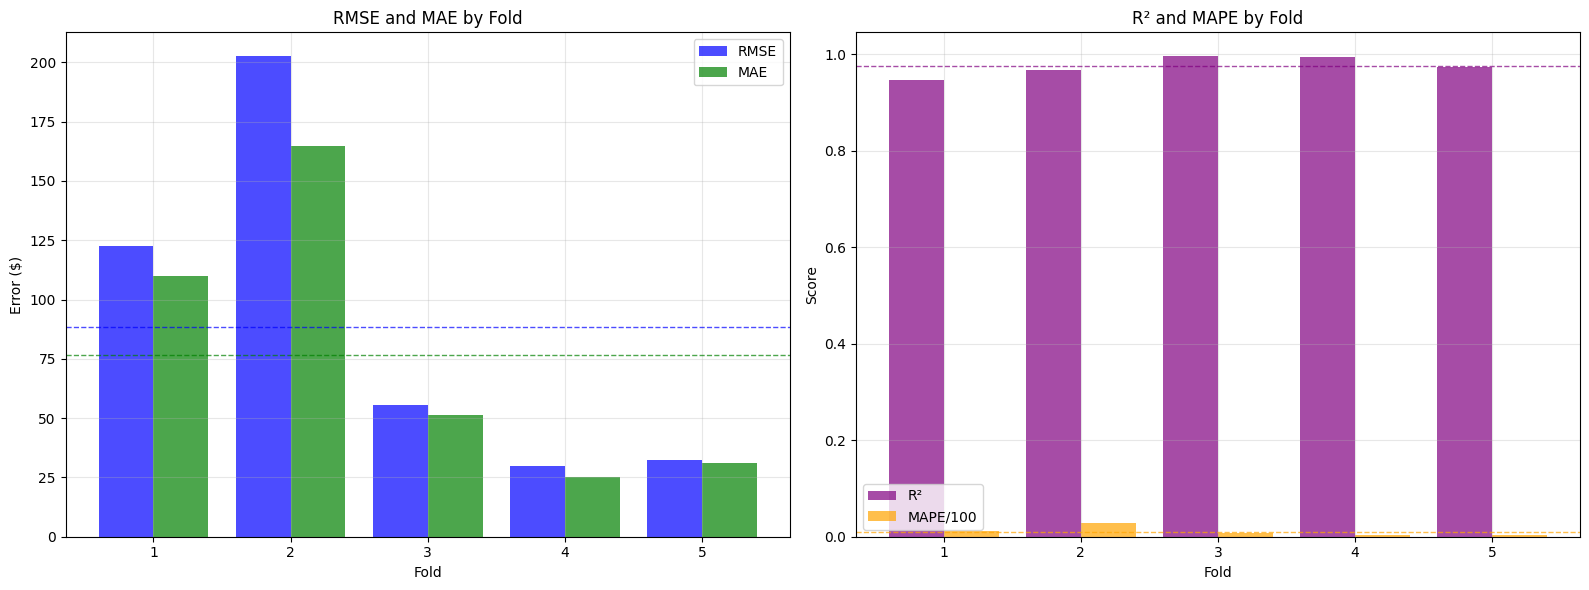

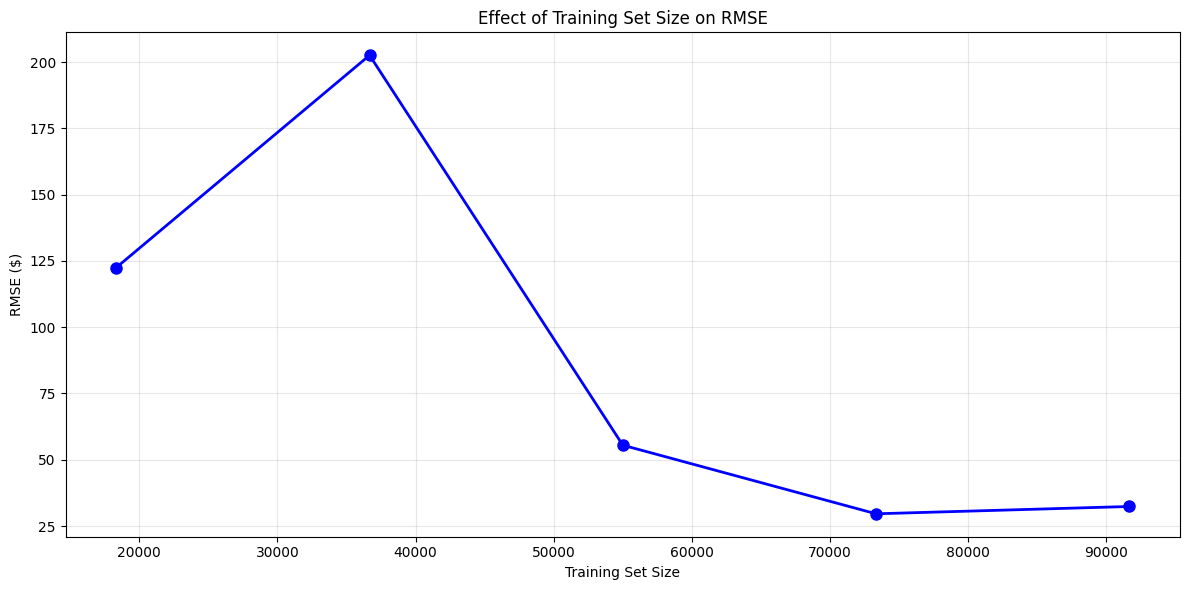


Step 3: Training final model...
Training set: 74720 samples
Validation set: 18680 samples
Test set: 16499 samples
Epoch 1/50:
  Train Loss: 0.002589
  Val Loss: 0.000235, Val RMSE: 0.015334
  Val RMSE (original scale): 101.30
  Learning rate: 0.001000
Epoch 5/50:
  Train Loss: 0.000245
  Val Loss: 0.000174, Val RMSE: 0.013175
  Val RMSE (original scale): 87.04
  Learning rate: 0.001000
Epoch 10/50:
  Train Loss: 0.000229
  Val Loss: 0.000006, Val RMSE: 0.002542
  Val RMSE (original scale): 16.79
  Learning rate: 0.001000
Epoch 15/50:
  Train Loss: 0.000223
  Val Loss: 0.000005, Val RMSE: 0.002261
  Val RMSE (original scale): 14.94
  Learning rate: 0.001000
Epoch 20/50:
  Train Loss: 0.000210
  Val Loss: 0.000009, Val RMSE: 0.003010
  Val RMSE (original scale): 19.88
  Learning rate: 0.001000
Early stopping triggered after 22 epochs

Final Model Test Results:
RMSE: $18.14
MAE: $16.88
R²: 0.9873
MAPE: 0.18%


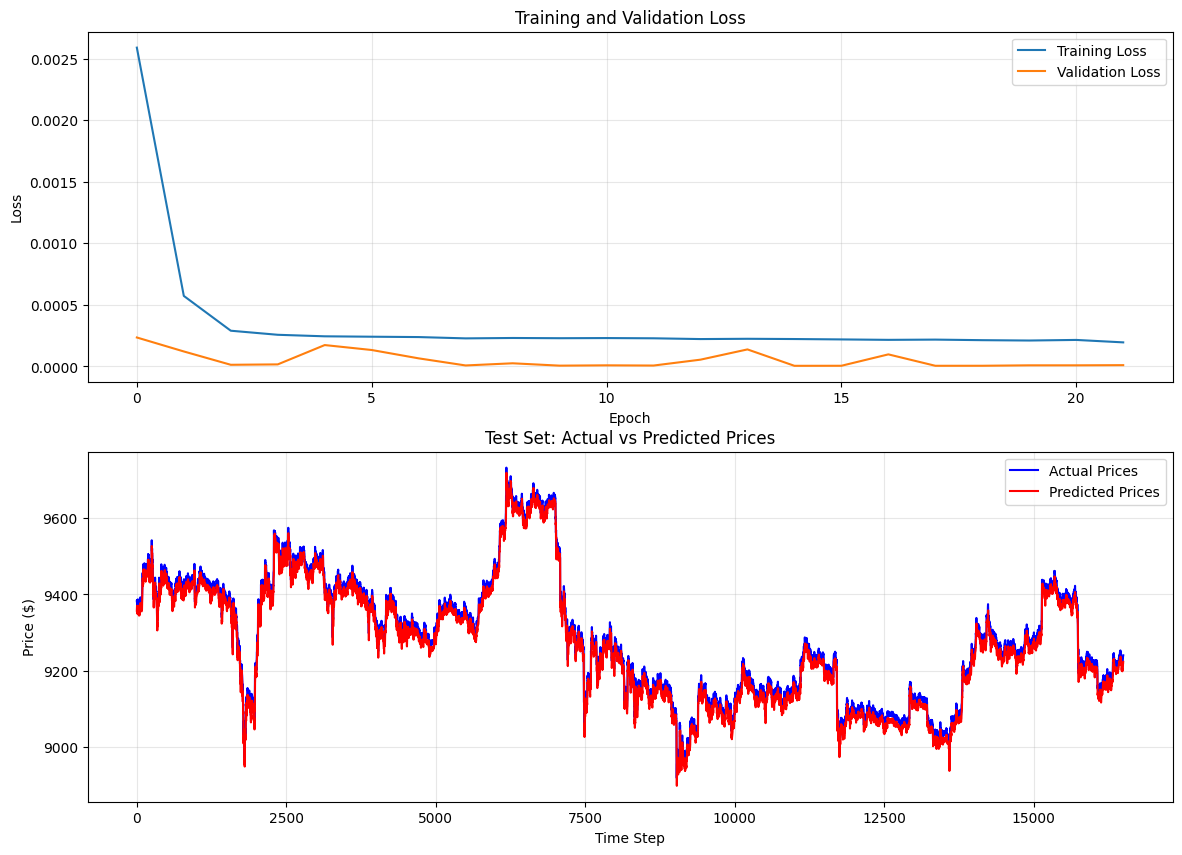

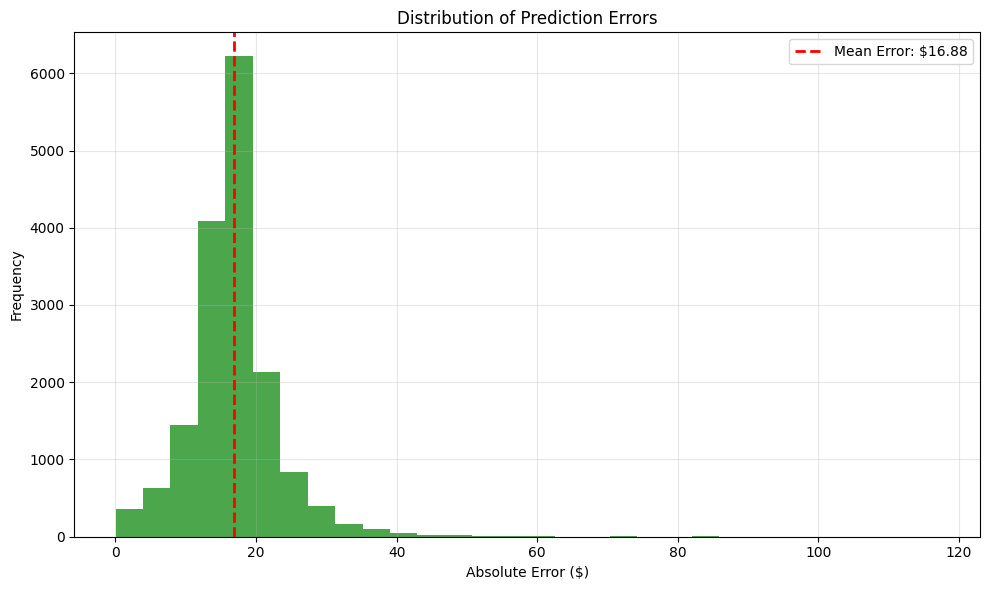

Model saved to final_bitcoin_lstm_model.pth
Scaler saved to final_bitcoin_scaler.pkl

Step 4: Example prediction with the trained model...
Sample prediction:
  Actual price: $9223.66
  Predicted price: $9206.55
  Absolute error: $17.11
  Relative error: 0.19%

Total execution time: 1204.68 seconds (20.08 minutes)


In [11]:
def main(data_path):
    """
    Main function to run the complete pipeline.
    
    Args:
        data_path (str): Path to the data file
    """
    # Set start time
    start_time = time.time()
    
    # 1. Load and preprocess data
    print("Step 1: Loading and preprocessing data...")
    all_sequences, all_targets, scaler, prices_normalized = load_and_preprocess_data(data_path)
    
    # 2. Perform time-series cross-validation
    print("\nStep 2: Performing time-series cross-validation...")
    cv_results = time_series_cross_validation(
        all_sequences, 
        all_targets, 
        scaler, 
        n_folds=5,
        input_size=all_sequences.shape[2],
        hidden_size=64
    )
    
    # Visualize cross-validation results
    visualize_cv_results(cv_results)
    
    # 3. Train final model with the best configuration
    print("\nStep 3: Training final model...")
    final_model, history, test_results = train_final_model(
        all_sequences, 
        all_targets, 
        scaler,
        test_size=0.15,
        input_size=all_sequences.shape[2],
        hidden_size=64
    )
    
    # 4. Example of making a prediction
    print("\nStep 4: Example prediction with the trained model...")
    
    # Get a sample from the test data
    sample_idx = np.random.randint(0, len(test_results['original_targets']))
    sample_features = all_sequences[-len(test_results['original_targets'])+sample_idx]
    actual_price = test_results['original_targets'][sample_idx]
    
    # Make prediction
    predicted_price = predict_bitcoin_price(
        sample_features,
        model_path='final_bitcoin_lstm_model.pth',
        scaler_path='final_bitcoin_scaler.pkl',
        has_features=True,
        input_size=all_sequences.shape[2]
    )
    
    print(f"Sample prediction:")
    print(f"  Actual price: ${actual_price:.2f}")
    print(f"  Predicted price: ${predicted_price:.2f}")
    print(f"  Absolute error: ${abs(actual_price - predicted_price):.2f}")
    print(f"  Relative error: {abs(actual_price - predicted_price) / actual_price * 100:.2f}%")
    
    # Calculate execution time
    end_time = time.time()
    execution_time = end_time - start_time
    print(f"\nTotal execution time: {execution_time:.2f} seconds ({execution_time/60:.2f} minutes)")
    
    return final_model, scaler, cv_results, test_results

# Run the code
if __name__ == "__main__":
    data_path = "BTC_train_data.json"  # Replace with your actual data path
    model, scaler, cv_results, test_results = main(data_path)

Successfully loaded BTC_data.csv with 200000 rows

First 5 rows of the dataset:
             timestamp     open     high      low    close     volume  \
0  2020-01-01 00:00:00  7195.24  7196.25  7178.64  7179.78  95.509133   
1  2020-01-01 00:05:00  7179.76  7191.77  7178.20  7191.07  59.365225   
2  2020-01-01 00:10:00  7193.15  7193.53  7180.24  7180.97  48.068510   
3  2020-01-01 00:15:00  7180.97  7186.40  7177.35  7178.29  32.192929   
4  2020-01-01 00:20:00  7177.71  7182.46  7175.47  7176.96  49.027397   

      close_time  quote_asset_volume  number_of_trades  \
0  1577837099999       686317.136252              1127   
1  1577837399999       426481.260364               631   
2  1577837699999       345446.503019               694   
3  1577837999999       231162.555424               576   
4  1577838299999       351927.893881               710   

   taker_buy_base_asset_volume  taker_buy_quote_asset_volume  ignore  
0                    32.773245                 235537.295045 

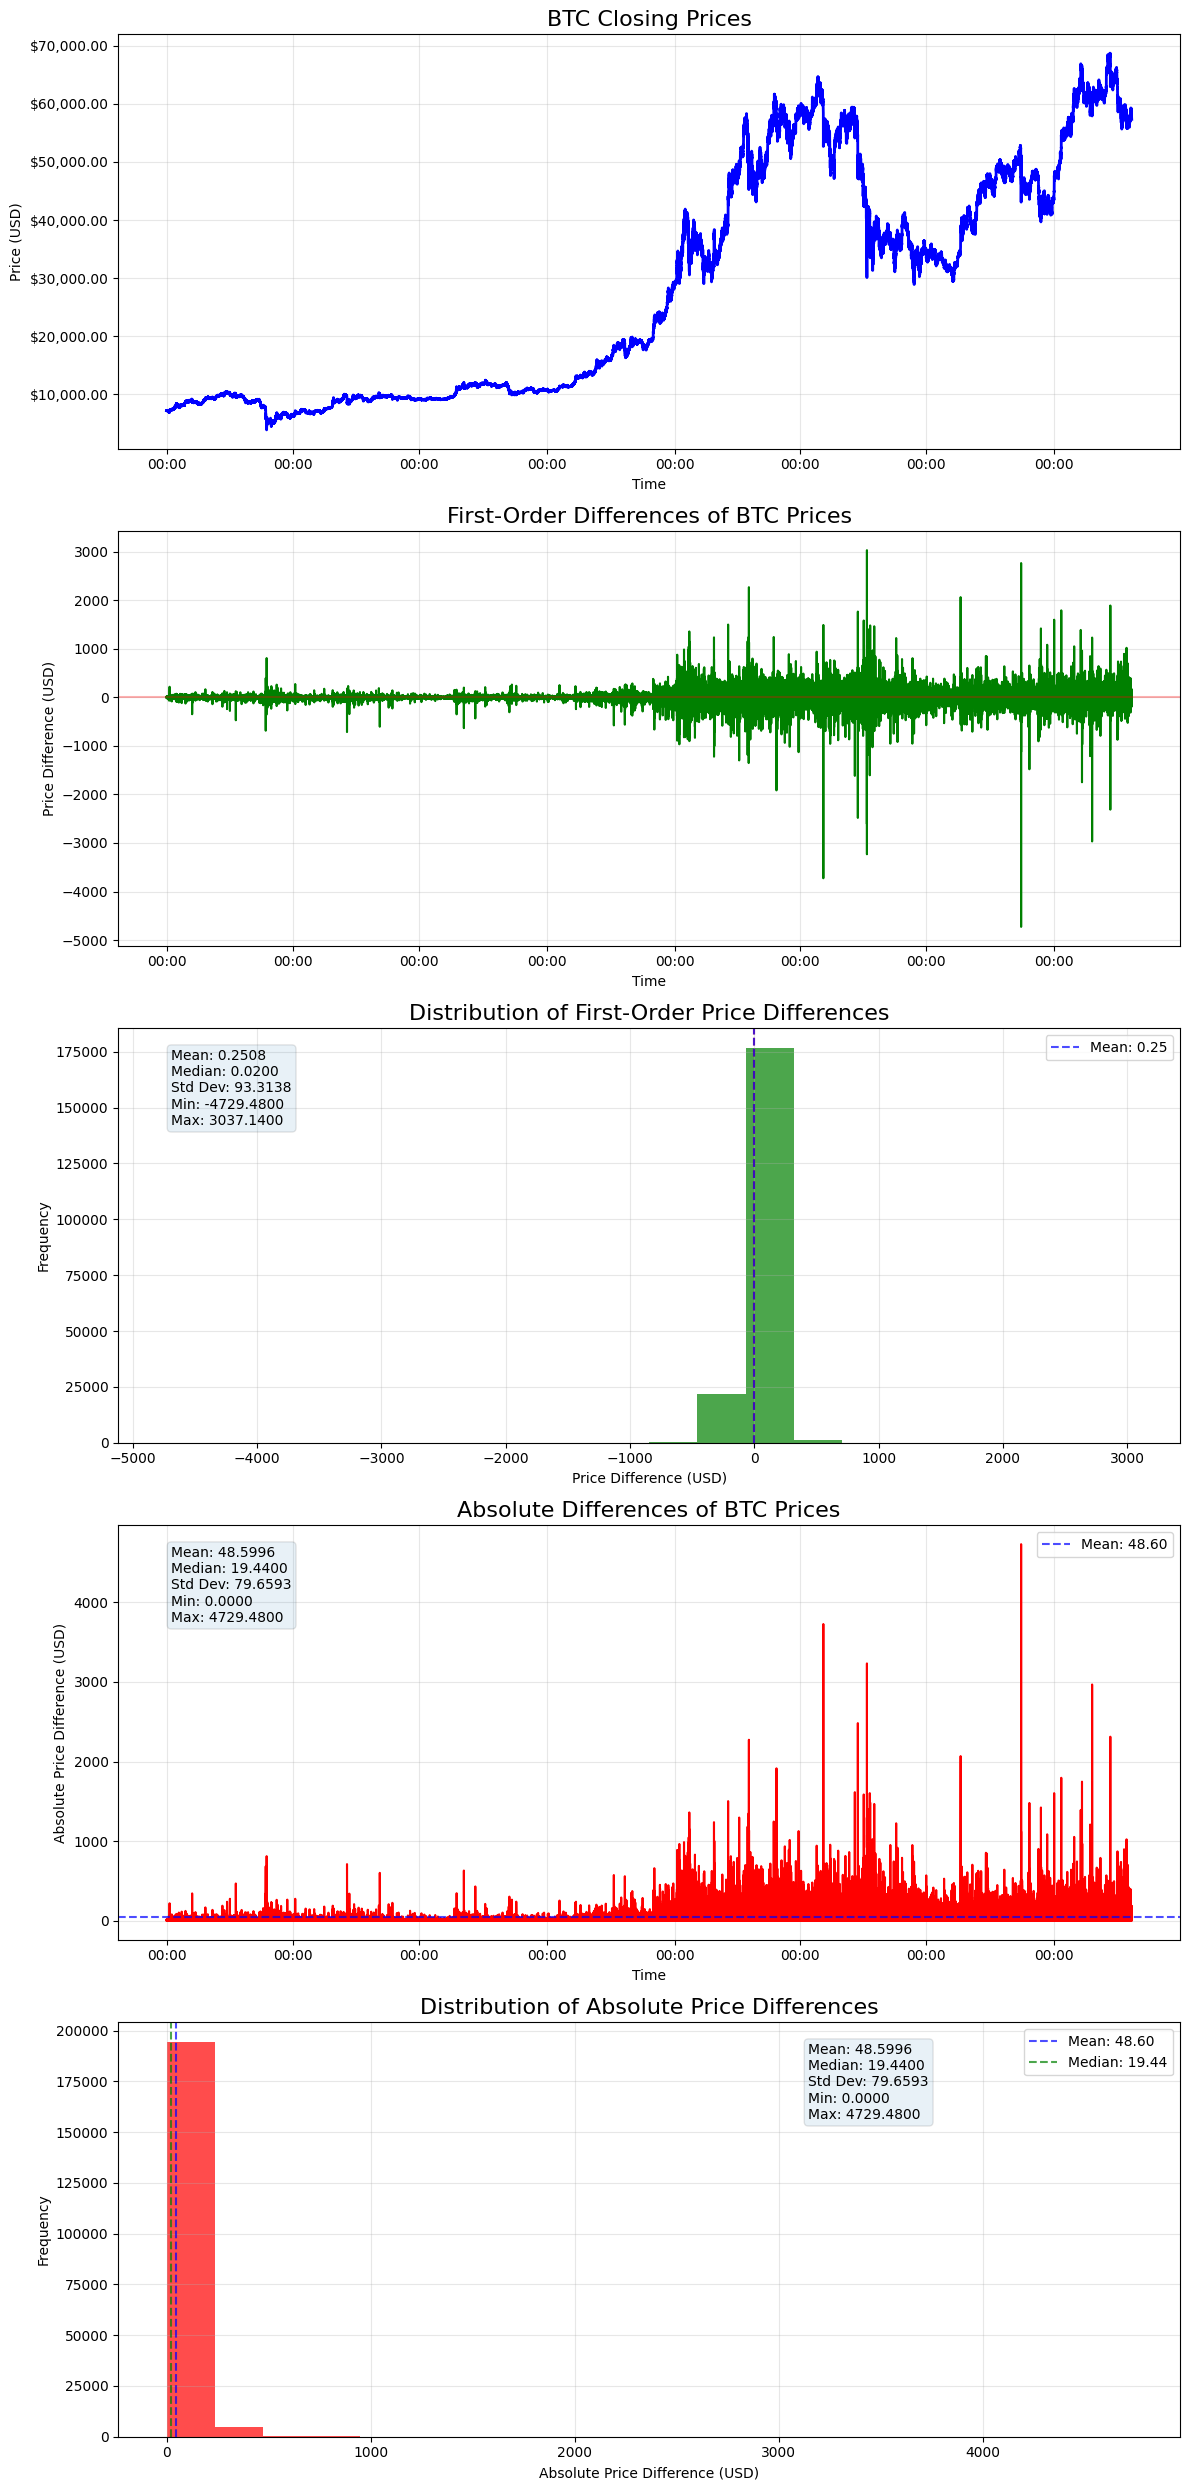


Bollinger Bands calculated with 20-period window

Total price movement: $50157.16 (698.59%)
Volatility (std dev of daily returns): 0.27%


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter

# Load the full BTC_data.csv file
try:
    # Load the CSV file
    df = pd.read_csv('BTC_data.csv')
    print(f"Successfully loaded BTC_data.csv with {len(df)} rows")
    
    # Print the first few rows to verify data
    print("\nFirst 5 rows of the dataset:")
    print(df.head())
    
    # Print column information
    print("\nDataset columns:")
    print(df.columns.tolist())
    
    # Check for missing values in close price
    missing_close = df['close'].isnull().sum()
    print(f"\nMissing values in close price: {missing_close}")
    
    # Summary statistics of closing prices
    print("\nSummary statistics of closing prices:")
    print(df['close'].describe())
    
except FileNotFoundError:
    print("BTC_data.csv file not found. Using sample data instead.")
    # Sample data from the provided excerpt as fallback
    data = {
        'timestamp': [
            '2020-01-01 00:00:00', '2020-01-01 00:05:00', '2020-01-01 00:10:00', 
            '2020-01-01 00:15:00', '2020-01-01 00:20:00', '2020-01-01 00:25:00',
            '2020-01-01 00:30:00', '2020-01-01 00:35:00', '2020-01-01 00:40:00',
            '2020-01-01 00:45:00'
        ],
        'close': [
            7179.78, 7191.07, 7180.97, 7178.29, 7176.96, 
            7178.45, 7180.68, 7177.53, 7179.56, 7182.94
        ]
    }
    df = pd.DataFrame(data)

# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Calculate first-order difference
df['price_diff'] = df['close'].diff()

# Calculate absolute difference
df['abs_price_diff'] = df['price_diff'].abs()

# Set up the figure and subplots
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(12, 25))

# 1. Plot closing prices
ax1.plot(df['timestamp'], df['close'], 'b-', linewidth=2)
ax1.set_title('BTC Closing Prices', fontsize=16)
ax1.set_xlabel('Time')
ax1.set_ylabel('Price (USD)')
ax1.grid(True, alpha=0.3)

# Format x-axis to show readable dates
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# Format y-axis to show dollar values
def dollar_formatter(x, pos):
    return f'${x:,.2f}'
ax1.yaxis.set_major_formatter(FuncFormatter(dollar_formatter))

# 2. Plot first-order differences
ax2.plot(df['timestamp'][1:], df['price_diff'][1:], 'g-', linewidth=1.5)
ax2.axhline(y=0, color='r', linestyle='-', alpha=0.3)
ax2.set_title('First-Order Differences of BTC Prices', fontsize=16)
ax2.set_xlabel('Time')
ax2.set_ylabel('Price Difference (USD)')
ax2.grid(True, alpha=0.3)

# Format x-axis for differences plot
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# 3. Plot distribution of price differences
# Skip the first row since it's NaN
valid_diffs = df['price_diff'][1:].dropna()
ax3.hist(valid_diffs, bins=20, alpha=0.7, color='green')
ax3.axvline(x=0, color='r', linestyle='--', alpha=0.7)
ax3.axvline(x=valid_diffs.mean(), color='blue', linestyle='--', alpha=0.7, 
            label=f'Mean: {valid_diffs.mean():.2f}')
ax3.set_title('Distribution of First-Order Price Differences', fontsize=16)
ax3.set_xlabel('Price Difference (USD)')
ax3.set_ylabel('Frequency')
ax3.grid(True, alpha=0.3)
ax3.legend()

# Add statistical information to the distribution plot
stats_text = (
    f'Mean: {valid_diffs.mean():.4f}\n'
    f'Median: {valid_diffs.median():.4f}\n'
    f'Std Dev: {valid_diffs.std():.4f}\n'
    f'Min: {valid_diffs.min():.4f}\n'
    f'Max: {valid_diffs.max():.4f}'
)
ax3.text(0.05, 0.95, stats_text, transform=ax3.transAxes, 
         verticalalignment='top', bbox=dict(boxstyle='round', alpha=0.1))

# 4. Plot absolute differences
valid_abs_diffs = df['abs_price_diff'][1:].dropna()
ax4.plot(df['timestamp'][1:], valid_abs_diffs, 'r-', linewidth=1.5)
ax4.set_title('Absolute Differences of BTC Prices', fontsize=16)
ax4.set_xlabel('Time')
ax4.set_ylabel('Absolute Price Difference (USD)')
ax4.grid(True, alpha=0.3)

# Format x-axis for absolute differences plot
ax4.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# Add a horizontal line for the mean absolute difference
mean_abs_diff = valid_abs_diffs.mean()
ax4.axhline(y=mean_abs_diff, color='blue', linestyle='--', alpha=0.7,
            label=f'Mean: {mean_abs_diff:.2f}')
ax4.legend()

# Add statistical information to the absolute differences plot
abs_stats_text = (
    f'Mean: {valid_abs_diffs.mean():.4f}\n'
    f'Median: {valid_abs_diffs.median():.4f}\n'
    f'Std Dev: {valid_abs_diffs.std():.4f}\n'
    f'Min: {valid_abs_diffs.min():.4f}\n'
    f'Max: {valid_abs_diffs.max():.4f}'
)
ax4.text(0.05, 0.95, abs_stats_text, transform=ax4.transAxes, 
         verticalalignment='top', bbox=dict(boxstyle='round', alpha=0.1))

# 5. Plot distribution of absolute differences
ax5.hist(valid_abs_diffs, bins=20, alpha=0.7, color='red')
ax5.axvline(x=valid_abs_diffs.mean(), color='blue', linestyle='--', alpha=0.7, 
            label=f'Mean: {valid_abs_diffs.mean():.2f}')
ax5.axvline(x=valid_abs_diffs.median(), color='green', linestyle='--', alpha=0.7, 
            label=f'Median: {valid_abs_diffs.median():.2f}')
ax5.set_title('Distribution of Absolute Price Differences', fontsize=16)
ax5.set_xlabel('Absolute Price Difference (USD)')
ax5.set_ylabel('Frequency')
ax5.grid(True, alpha=0.3)
ax5.legend()

# Add statistical information to the absolute difference distribution plot
ax5.text(0.65, 0.95, abs_stats_text, transform=ax5.transAxes, 
         verticalalignment='top', bbox=dict(boxstyle='round', alpha=0.1))

plt.tight_layout()
plt.show()

# Additional analysis for the full dataset

# Calculate daily returns (percentage change)
df['daily_return'] = df['close'].pct_change() * 100

# Calculate rolling statistics (if you have enough data)
if len(df) > 20:
    df['20_period_ma'] = df['close'].rolling(window=20).mean()
    df['20_period_std'] = df['close'].rolling(window=20).std()
    
    # Calculate Bollinger Bands
    df['upper_band'] = df['20_period_ma'] + (df['20_period_std'] * 2)
    df['lower_band'] = df['20_period_ma'] - (df['20_period_std'] * 2)
    
    print("\nBollinger Bands calculated with 20-period window")

# Calculate total price movement
total_movement = df['close'].iloc[-1] - df['close'].iloc[0]
percent_change = (total_movement / df['close'].iloc[0]) * 100
print(f"\nTotal price movement: ${total_movement:.2f} ({percent_change:.2f}%)")

# Calculate volatility (standard deviation of returns)
volatility = df['daily_return'].std()
print(f"Volatility (std dev of daily returns): {volatility:.2f}%")

# You can save the processed data to a new CSV file if needed
# df.to_csv('processed_btc_data.csv', index=False)